# Setup Variables

In [1]:
from pathlib import Path
import os
base = Path().cwd()
DATASET = str(base).split('/')[4]
print(DATASET)

# switch to home directory to import helper scripts
os.chdir('..')
base = Path().cwd()

print(base)

PREFIX = 'Adam-128-40'
FILENAME_POSTFIX = f"{DATASET}_{PREFIX}"

FashionMNIST
/home/ah19/runtime-monitoring


# Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [3]:
# import sys
# sys.path.append(REPO_PATH + '/utilities')
# sys.path.append(f'{REPO_PATH}/{DATASET}/trainingModels')

In [4]:
from utilities.utils import *
from utilities.pcaFunctions import *
from utilities.scaleFunctions import *
from utilities.plotFunctions import *
from utilities.pathManager import fetchPaths

In [5]:
paths = fetchPaths(base, DATASET)

path = paths[DATASET.lower()]
path_dataset = paths['dataset']
path_lastHiddenLayer = paths['lastHiddenLayer'] / FILENAME_POSTFIX
path_lastHiddenLayer_raw = paths['lastHiddenLayer_raw'] / FILENAME_POSTFIX
path_lastHiddenLayer_pca = paths['lastHiddenLayer_pca'] / FILENAME_POSTFIX / 'Classes'
path_savedModels = paths['savedModels'] / FILENAME_POSTFIX

path, path_savedModels

(PosixPath('/home/ah19/runtime-monitoring/FashionMNIST'),
 PosixPath('/home/ah19/runtime-monitoring/FashionMNIST/savedModels/FashionMNIST_Adam-128-40'))

# Import Data

In [6]:
df = pd.read_csv(path_lastHiddenLayer_raw / f'{FILENAME_POSTFIX}_train.csv')
f"Accuracy for train data: {df['true'].sum() / df.shape[0]}"

'Accuracy for train data: 0.9592833333333334'

In [7]:
df_test = pd.read_csv(path_lastHiddenLayer_raw / f'{FILENAME_POSTFIX}_test.csv')
f"Accuracy for test data: {df_test['true'].sum() / df_test.shape[0]}"

'Accuracy for test data: 0.9301'

In [8]:
NUM_NEURONS = int(PREFIX.split('-')[-1])
NUM_NEURONS

40

# EDA

### Balanced Classes

In [9]:
load_rc_settings_general()

<Axes: xlabel='y'>

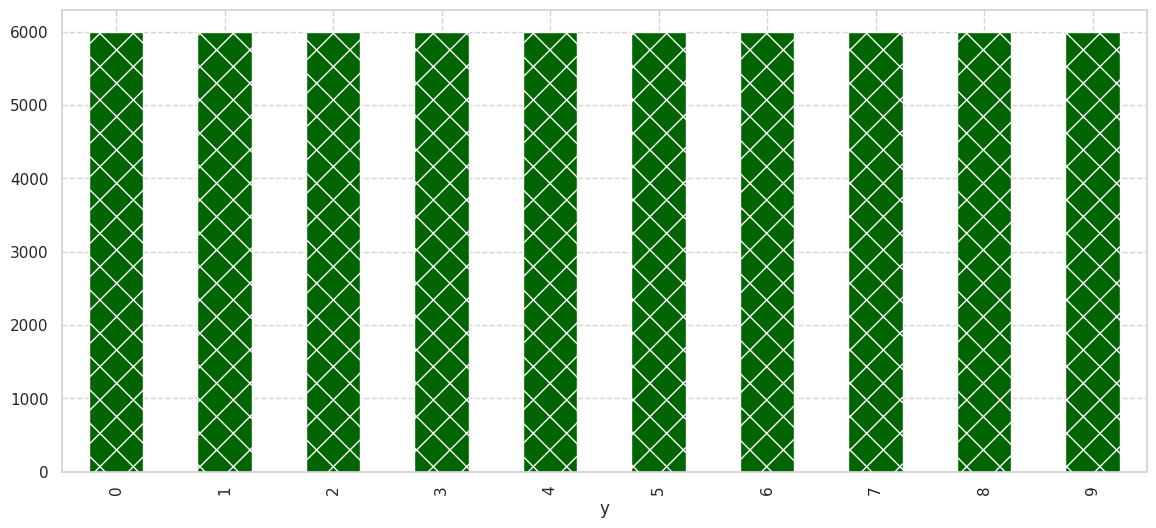

In [10]:
df.y.value_counts().sort_index().plot.bar(color='darkgreen', hatch='x', edgecolor='white')

<Axes: title={'center': 'Test'}, xlabel='y'>

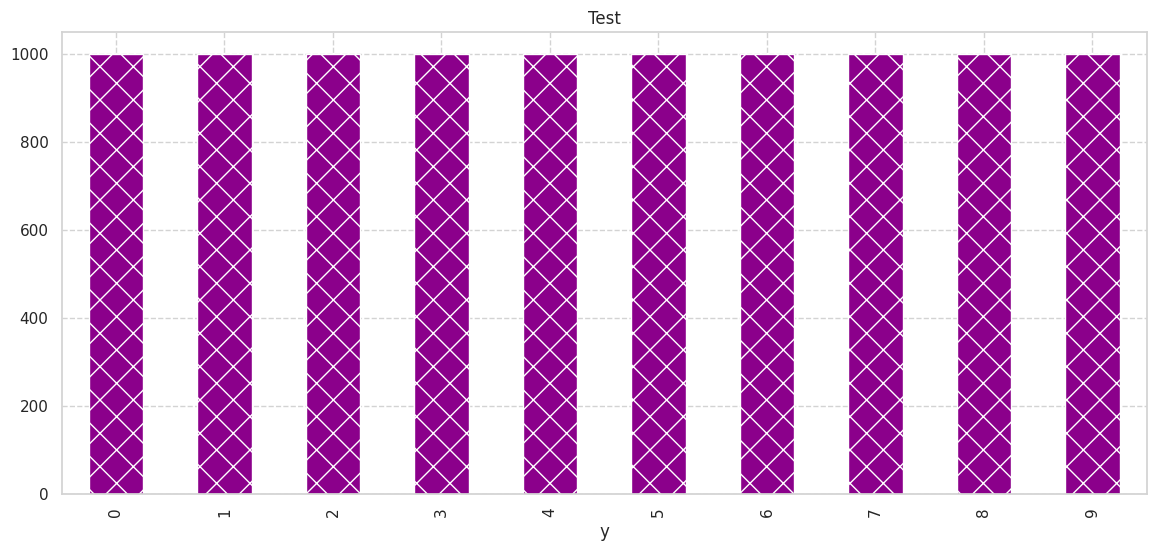

In [11]:
df_test.y.value_counts().sort_index().plot.bar(color='darkmagenta', hatch='x', edgecolor='white', title="Test")

### Error Rate per Class

In [12]:
def plot_error_rate(df, stage):
    stage_color = {'train':'teal','validation':'navy','test':'indigo'}
    
    temp = df[['y', 'true']].groupby('y').agg(['sum', 'count'])
    temp.columns = ['true', 'false']
    total = temp['false'].copy()
    temp['false'] = temp['false'] - temp['true']
    temp['true'] = temp['true'] / total
    temp['false'] = temp['false'] / total

    temp.plot(kind='bar', stacked=True, color=[stage_color[stage.lower()], 'red'], hatch='x', edgecolor='snow',
              xlabel='', title=f"{stage} - MAX: {round(temp['false'].max(), 3)}, AVG: {round(temp['false'].mean(), 3)}")
    plt.axhline(temp['true'].min(), c='black', linestyle='--')
    del temp
    plt.show()

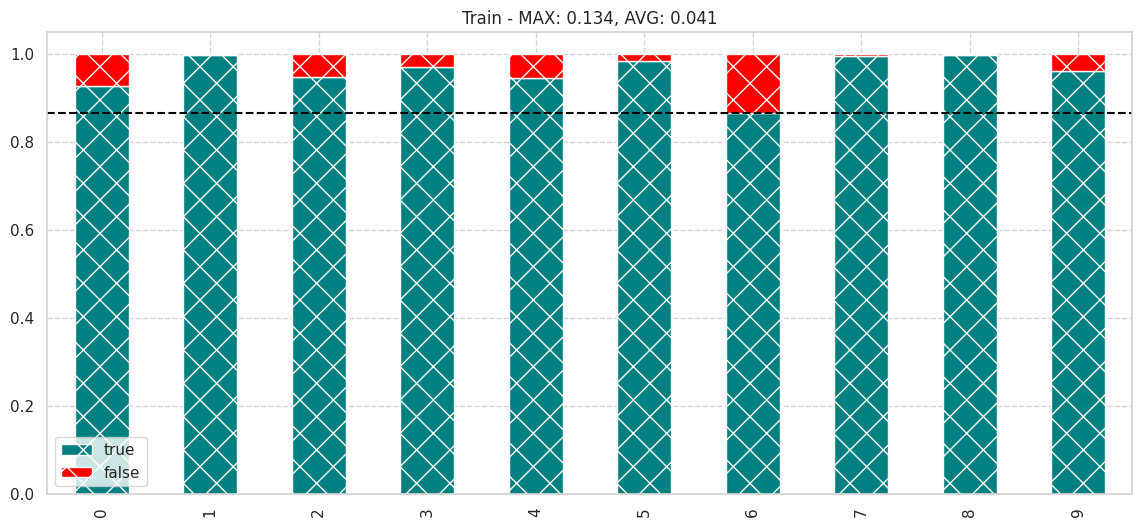

In [13]:
plot_error_rate(df, 'Train')

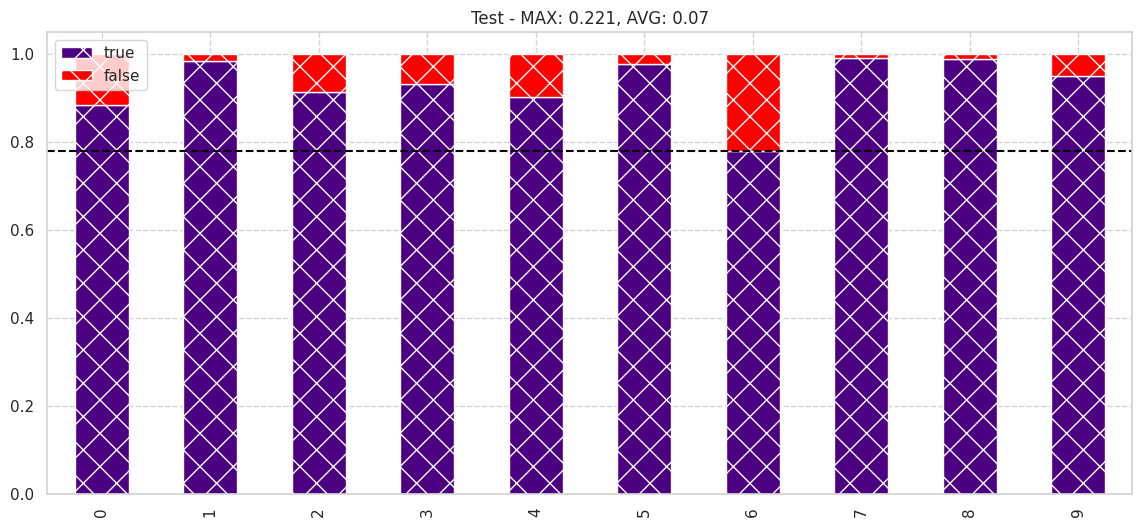

In [14]:
plot_error_rate(df_test, 'Test')

## Train: true vs false

<Axes: xlabel='y,true'>

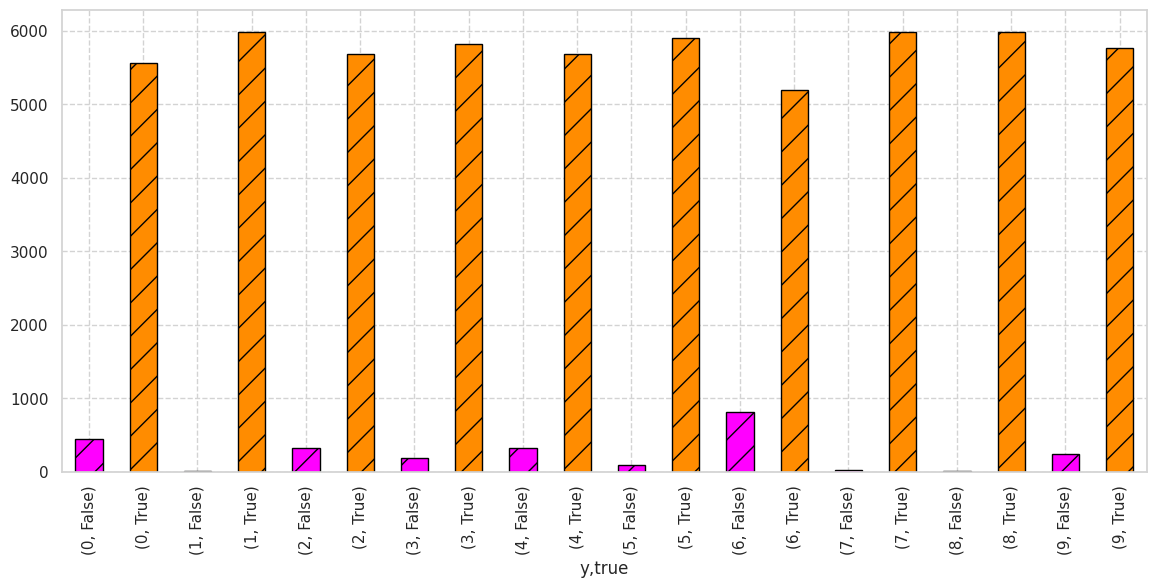

In [15]:
df[['y', 'true']].value_counts().sort_index().plot(kind='bar', color=['magenta', 'darkorange'], hatch='/', edgecolor='black')

# Neuron Histogram Single

In [16]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from ipywidgets import interactive_output, widgets, Dropdown, fixed
from IPython import display

In [17]:
scaler = StandardScaler()
robust = RobustScaler()
power = PowerTransformer()
minmax = MinMaxScaler()

In [18]:
numNeurons = df.shape[0] - 2

scaler.fit(df.iloc[:, :numNeurons])
robust.fit(df.iloc[:, :numNeurons])
power.fit(df.iloc[:, :numNeurons])
minmax.fit(df.iloc[:, :numNeurons])

MinMaxScaler()

### Distribution

In [19]:
NUM_BINS=30

In [20]:
def applyScalers(df):
    dfs = {}
    
    dfs['raw'] = df

    dfs['scaler'] = pd.DataFrame( scaler.transform(df.iloc[:, :numNeurons]), columns=df.columns[:numNeurons] )
    dfs['scaler']['y'] = df['y']
    dfs['scaler']['true'] = df['true']

    dfs['robust'] = pd.DataFrame( robust.transform(df.iloc[:, :numNeurons]), columns=df.columns[:numNeurons] )
    dfs['robust']['y'] = df['y']
    dfs['robust']['true'] = df['true']

    dfs['power'] = pd.DataFrame( power.transform(df.iloc[:, :numNeurons]), columns=df.columns[:numNeurons] )
    dfs['power']['y'] = df['y']
    dfs['power']['true'] = df['true']

    dfs['minmax'] = pd.DataFrame( minmax.transform(df.iloc[:, :numNeurons]), columns=df.columns[:numNeurons] )
    dfs['minmax']['y'] = df['y']
    dfs['minmax']['true'] = df['true']
    
    return dfs

In [21]:
df_single = {
    'train': applyScalers(df),
    'test': applyScalers(df_test),
}

In [22]:
def hist_neuron(df, neuron='x0', stage='test'):
    histRange = (-3, 3)
    fig, axs = plt.subplots(3, 2, figsize=(16,12))
    
    fig.suptitle(f'Compare Scalers for neuron [{neuron}] - {stage.capitalize()}')

    axs[0,0].set_title('Power Transform')
    axs[0,1].set_title('Robust Scale')
    axs[1,0].set_title('Standard Scale')
    axs[1,1].set_title('MinMax')
    axs[2,0].set_title('Raw')

    axs[0,0].hist(df[stage]['power'][neuron],
                  bins=NUM_BINS, alpha=0.8, color='red', range=histRange)
    axs[0,1].hist(df[stage]['robust'][neuron],
                  bins=NUM_BINS, alpha=0.8, color='teal', range=histRange)
    axs[1,0].hist(df[stage]['scaler'][neuron],
                  bins=NUM_BINS, alpha=0.8, color='orange', range=histRange)
    axs[1,1].hist(df[stage]['minmax'][neuron],
                  bins=NUM_BINS, alpha=0.8, color='indigo', range=histRange)
    axs[2,0].hist(df[stage]['raw'][neuron],
                  bins=NUM_BINS, alpha=0.8, color='indigo', range=histRange)

    plt.show()

In [23]:
plot_widget = widgets.interact(
    hist_neuron,
    df=fixed(df_single),
    neuron=df.columns[:numNeurons].tolist(),
    stage=df_single.keys()
)

interactive(children=(Dropdown(description='neuron', options=('x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', …

### Shift mean to center

In [24]:
def hist_neuron_shift_mean(df, neuron='x0', stage='test'):
    histRange = (-3, 3)
    fig, axs = plt.subplots(3, 2, figsize=(16,12))
    
    fig.suptitle(f'Compare Scalers for neuron [{neuron}] - {stage.capitalize()} with mean shift to 0')

    axs[0,0].set_title('Power Transform')
    axs[0,1].set_title('Robust Scale')
    axs[1,0].set_title('Standard Scale')
    axs[1,1].set_title('MinMax')
    axs[2,0].set_title('Raw')
    
    x_power =  df[stage]['power'][neuron]
    x_robust = df[stage]['robust'][neuron]
    x_scaler = df[stage]['scaler'][neuron]
    x_minmax = df[stage]['minmax'][neuron]
    x =        df[stage]['raw'][neuron]
    
    x_power = x_power + (0 - x_power.mean() )
    x_robust = x_robust + (0 - x_robust.mean() )
    x_scaler = x_scaler + (0 - x_scaler.mean() )
    x_minmax = x_minmax + (0 - x_minmax.mean() )
    x = x + (0 - x.mean() )

    axs[0,0].hist(x_power, bins=NUM_BINS, alpha=0.8, color='red', range=histRange)
    axs[0,1].hist(x_robust, bins=NUM_BINS, alpha=0.8, color='teal', range=histRange)
    axs[1,0].hist(x_scaler, bins=NUM_BINS, alpha=0.8, color='orange', range=histRange)
    axs[1,1].hist(x_minmax, bins=NUM_BINS, alpha=0.8, color='indigo', range=histRange)
    axs[2,0].hist(x, bins=NUM_BINS, alpha=0.8, color='indigo', range=histRange)

    plt.show()

In [25]:
plot_widget_shift_mean = widgets.interact(
    hist_neuron_shift_mean,
    df=fixed(df_single),
    neuron=df.columns[:numNeurons].tolist(),
    stage=df_single.keys()
)

interactive(children=(Dropdown(description='neuron', options=('x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', …

# building function shift 0

In [55]:
temp = df_single['train']['scaler'].iloc[:, :numNeurons]
temp['y'] = df_single['train']['scaler']['y']
temp = temp - temp.mean()

In [56]:
( temp['x0'].values == (df_single['train']['scaler']['x0'] - df_single['train']['scaler']['x0'].mean()).values ).all()

True

<AxesSubplot:ylabel='Frequency'>

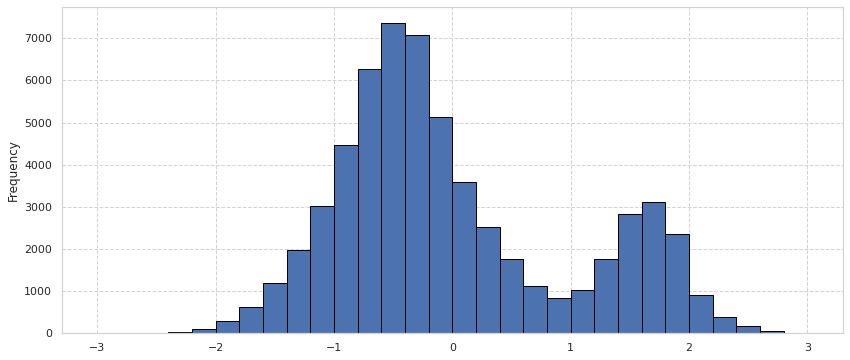

In [57]:
temp['x0'].plot.hist(bins=NUM_BINS, range=(-3,3))

# Neuron Histogram Classes

In [26]:
scalers = fitScalerClasses(df, 'y', NUM_NEURONS)

df_classes = {
    'train': applyScalerClasses(scalers, df, 'y'),
    'test': applyScalerClasses(scalers, df_test, 'y'),
}

In [27]:
def hist_neuron_classes_shift_mean(df, df_single, neuron='x0', clas=0, stage='test'):
    histRange = (-3, 3)
    fig, axs = plt.subplots(1, 2, figsize=(16,5))
    
    fig.suptitle(f'Standared Scalers for class [{clas}] and neuron [{neuron}] - {stage.capitalize()} with mean shift to 0')

    axs[0].set_title('Classes')
    axs[1].set_title('Single')
    
    x_classes =  df[stage].loc[ df[stage]['y'] == clas, neuron]
    x_single = df_single[stage]['scaler'].loc[ df_single[stage]['scaler']['y'] == clas, neuron]
    
    x_classes = x_classes + (0 - x_classes.mean() )
    x_single = x_single + (0 - x_single.mean() )

    axs[0].hist(x_classes, bins=50, alpha=0.8, color='red', range=histRange)
    axs[1].hist(x_single, bins=50, alpha=0.8, color='teal', range=histRange)

    plt.show()

In [28]:
plot_widget = widgets.interact(
    hist_neuron_classes_shift_mean,
    df=fixed(df_classes),
    df_single=fixed(df_single),
    neuron=df.columns[:NUM_NEURONS].tolist(),
    clas=df['y'].drop_duplicates().sort_values().tolist(),
    stage=df_classes.keys()
)

interactive(children=(Dropdown(description='neuron', options=('x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', …